<a href="https://colab.research.google.com/github/ismai-doc/Artificial-neural-network/blob/main/Test_technique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Génération des images IRMs avec VAE

L'objectif est de générer des nouvelles données à partir des données exitants. Pour parvenir à ce resultat, on commence par définir le modèle VAE et puis faire une interpolation linéaire entre les données d’entrées via l’espace latent. C’est-à-dire, on prend les données en entrées, on va les réduire progressivement avec un ensemble des couches de manière à récupérer à la sortie de cet encodeur une structure des données de petite taille qui sera une projection de nos données dans cet espace latent.



Le but de l’interpolation est de prédire des nouvelles données entre les exemples d’entrées pour générer des nouvelles données entre les données existantes. Pour ce faire, on utilise l’autoencodeur variationnel, qui va dans le premier temps encoder les exemples d’entrées afin de trouver leurs vecteurs latents.
Ensuite, les vecteurs latents seront interpolés entre eux pour trouver des vecteurs intermédiaires qui seront décodé pour générer les nouvelles données.



![picture](https://drive.google.com/uc?export=view&id=17ZlCRXtCfsEbhf08bAbRsBy5xJm_j7Tc)



### Les librairies

In [89]:
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, Layer
from tensorflow.keras.layers import Flatten, Input, Dense, Reshape
from matplotlib.widgets import Slider, Button, RadioButtons
from tensorflow.keras.utils import plot_model
from tensorflow.keras import metrics, losses
from tensorflow.keras.models import Model, save_model
from tensorflow.keras import backend as k
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
from tensorflow import shape
import tensorflow as tf
import nibabel as nib
import scipy.ndimage
import numpy as np
from sklearn.model_selection import train_test_split 

Je propose l'architecture ci-dessous. À chaque itération, on echantillonne deux images d’entrées (xi, xj) de notre jeu des données. Les deux images (xi
, xj ) sont encodées par l’encodeur et on obtient ces deux vecteurs latents (zi, zj).



![picture](https://drive.google.com/uc?export=view&id=1S5Jo043Lmnh7HL0x06Pi7g4YRjOSm1dj)



![picture](https://drive.google.com/uc?export=view&id=17ZlCRXtCfsEbhf08bAbRsBy5xJm_j7Tc)

In [90]:
from google.colab import files

up = files.upload()

Saving img0002_.nii.gz to img0002_.nii (1).gz


In [91]:
data = nib.load("img0002_.nii.gz").get_fdata()

[]

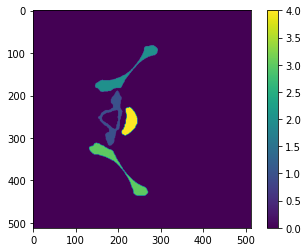

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(data[:,:,60])
plt.colorbar()
plt.plot()

In [93]:
import numpy as np
from matplotlib import cm

def normalize(data):
    data_min = np.min(data)
    return (data-data_min)/(np.max(data)-data_min)

In [94]:
# resampling of voxels 
def resample(data, old_spacing, new_spacing=[0.7207031, 0.7207031, 0.7207031]):
    
    old_spacing = np.asarray(old_spacing)
    new_spacing = np.asarray(new_spacing)
    old_spacing = [round(i,2) for i in old_spacing]
    scale_factor = old_spacing / new_spacing
    
    new_shape = data.shape * scale_factor
    new_shape = np.round(new_shape)
    zoom_factor = new_shape / data.shape
    new_spacing = old_spacing / zoom_factor
    new_spacing = np.asarray(new_spacing)
    
    data = scipy.ndimage.zoom(data, zoom_factor, order=1, prefilter=True)
    return data


data = resample(data, [0.7207031, 0.7207031, 3.0])
data = data[80:438, 101:333, 12:378]
print(data.shape) 

(358, 232, 366)


In [95]:
def scale_by(data, fac):
    mean = np.mean(data)
    return (data-mean)*fac + mean

transformed = np.clip(scale_by(np.clip(normalize(data)-0.1, 0, 1)**0.4, 2)-0.1, 0, 1)

In [96]:
IMG_DIM = 50

from skimage.transform import resize
resized = resize(transformed, (IMG_DIM, IMG_DIM, IMG_DIM), mode='constant')

In [97]:
def explode(data):
    shape_irm = np.array(data.shape)
    size = shape_irm[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_irm[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    plt.show()

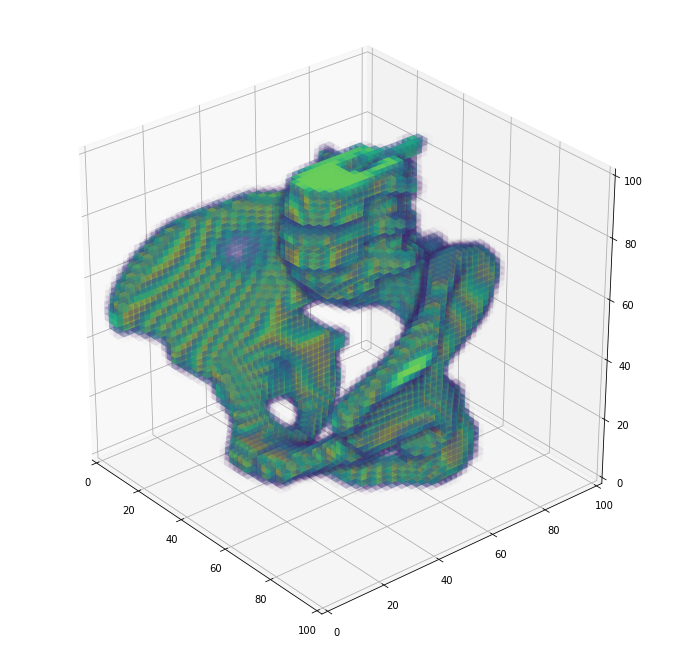

In [10]:
plot_cube(resized[:,::-1,:])

In [98]:
data= data[:232,:,:232]

In [99]:
# reshape the input images
image_size = data.shape[1]
data = data.reshape(-1, image_size, image_size, image_size, 1)

In [100]:
# network parameters
input_shape =  (image_size, image_size, image_size, 1)
batch_size = 128
kernel_size = (3,3,3)
latent_dim = 5
epochs = 100

In [101]:
# We use ( z_mean, z_log_var ) to sample z
class Sampling(Layer):
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = k.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 232, 232, 23 0                                            
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 116, 116, 116 896         input_5[0][0]                    
__________________________________________________________________________________________________
conv3d_7 (Conv3D)               (None, 58, 58, 58, 6 55360       conv3d_6[0][0]                   
__________________________________________________________________________________________________
conv3d_8 (Conv3D)               (None, 29, 29, 29, 1 221312      conv3d_7[0][0]                   
____________________________________________________________________________________________

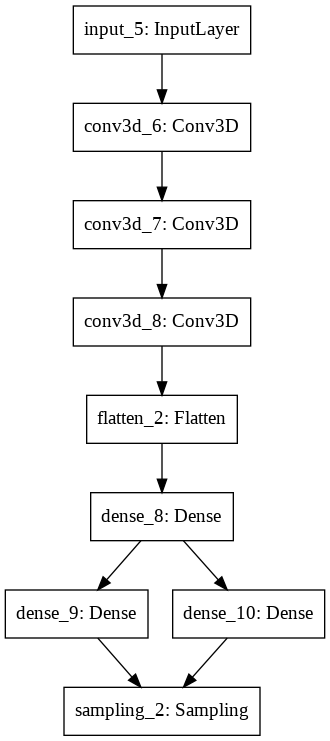

In [102]:
# encoder/decoder number of CNN layers and filters per layer
layers_filters = [32, 64, 128]


# first build the encoder model
encoder_inputs = Input(shape=input_shape)
x = encoder_inputs


# stack of Conv3D(32)-Conv3D(64)-Conv3D(128)
for filters in layers_filters:
    x = Conv3D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=(2,2,2),
               padding='same')(x)


shape = k.int_shape(x)
 
 
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(latent_dim)(x)    
z_log_var = Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z])
encoder.summary()

plot_model(encoder)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3121792)           18730752  
_________________________________________________________________
reshape_2 (Reshape)          (None, 29, 29, 29, 128)   0         
_________________________________________________________________
conv3d_transpose_8 (Conv3DTr (None, 58, 58, 58, 128)   442496    
_________________________________________________________________
conv3d_transpose_9 (Conv3DTr (None, 116, 116, 116, 64) 221248    
_________________________________________________________________
conv3d_transpose_10 (Conv3DT (None, 232, 232, 232, 32) 55328     
_________________________________________________________________
conv3d_transpose_11 (Conv3DT (None, 232, 232, 232, 1)  865 

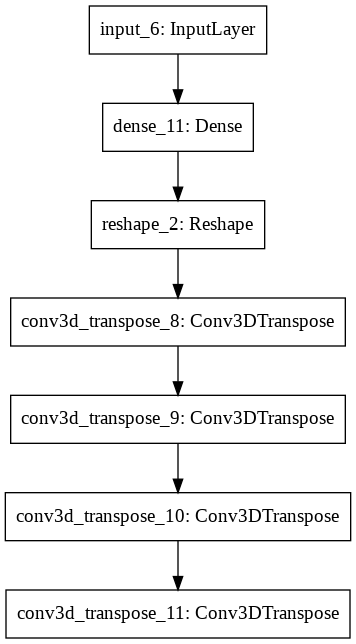

In [103]:
 # build the decoder
input_latents = Input(shape=(latent_dim,))
x = Dense(shape[1] * shape[2] * shape[3] * shape[4], activation='relu')(input_latents)
x = Reshape((shape[1], shape[2], shape[3], shape[4]))(x)



for filters in layers_filters[::-1]:
    x = Conv3DTranspose(filters=filters,
                        kernel_size=kernel_size, 
                        activation='relu', 
                        strides=(2,2,2), 
                        padding='same')(x)

decoder_outputs = Conv3DTranspose(1, kernel_size=kernel_size, activation="sigmoid", padding="same")(x)

decoder = Model(input_latents,  decoder_outputs)
decoder.summary()

plot_model(decoder)

In [104]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.1*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
callback = callbacks.EarlyStopping(monitor="loss", patience=20)
vae = VAE(encoder, decoder)
plot_model(vae)
vae.compile(optimizer="Adam")
#hist = vae.fit(data, epochs=epochs, batch_size=batch_size, callbacks=[callback])

vae.load_weights("vae_weights")

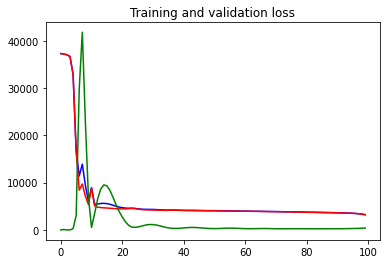

In [105]:
# Visualisation de l'erreur
loss     = hist.history[    'loss' ]
reconstruction_loss = hist.history['reconstruction_loss' ]
kl_loss = hist.history['kl_loss' ]
plt.figure()
epochs   = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, color='b' )
plt.plot  ( epochs, reconstruction_loss, color='r' )
plt.plot  ( epochs, kl_loss, color='g' )
plt.title ('Training and validation loss'   )
plt.show()

On prend α ∈ [0, 1] tel que zi→j (α) = (1 − α)zi + αzj pour faire l’interpolation linéaire. Ici, on va partir de l’image xi (pour α = 0 on a zi→j (α) = zi) vers l’image xj car pour α = 1, on a
zi→j (α) = zj
.


In [106]:
vec_latent = vae.encoder.predict(data.reshape(1,image_size,image_size,image_size,1))

In [108]:
data_decoded = vae.decoder.predict(vec_latent[0]).reshape(image_size, image_size, image_size)

In [109]:
print(data.shape, data_decoded.shape)

(1, 232, 232, 232, 1) (232, 232, 232)


In [110]:
irm = data.reshape(image_size, image_size, image_size)
irm.shape

(232, 232, 232)

In [111]:
def plot_data(data):
  # generate figure
  fig = plt.figure()
  fig, (ax1, ax2 ,ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(nrows=1, ncols=10, figsize=(80, 50))
  fig, (ax11, ax22 ,ax33, ax44, ax55, ax66, ax77, ax88, ax99, ax110) = plt.subplots(nrows=1, ncols=10, figsize=(80, 50))

  ax1.imshow(data[:, 20, :])
  ax2.imshow(data[:, 40, :])
  ax3.imshow(data[:, 60, :])
  ax4.imshow(data[:, 80, :])
  ax5.imshow(data[:, 100, :])
  ax6.imshow(data[:, 110, :])
  ax7.imshow(data[:, 120, :])
  ax8.imshow(data[:, 140, :])
  ax9.imshow(data[:, 160, :])
  ax10.imshow(data[:, 180, :])

  ax11.imshow(data_decoded[:, 20, :])
  ax22.imshow(data_decoded[:, 40, :])
  ax33.imshow(data_decoded[:, 60, :])
  ax44.imshow(data_decoded[:, 80, :])
  ax55.imshow(data_decoded[:, 100, :])
  ax66.imshow(data_decoded[:, 110, :])
  ax77.imshow(data_decoded[:, 120, :])
  ax88.imshow(data_decoded[:, 140, :])
  ax99.imshow(data_decoded[:, 160, :])
  ax110.imshow(data_decoded[:, 180, :])
  plt.show


<Figure size 432x288 with 0 Axes>

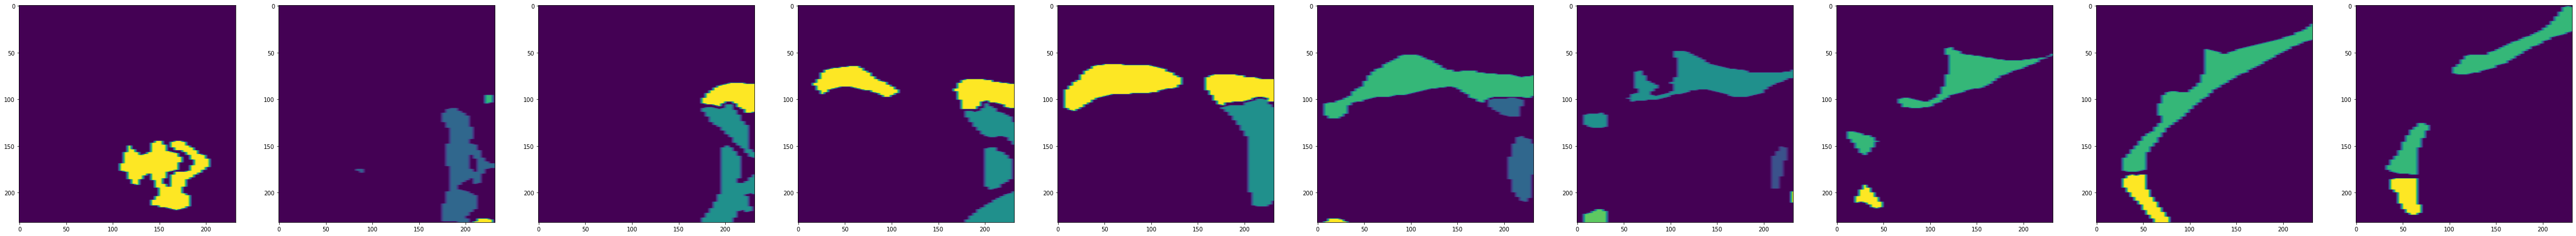

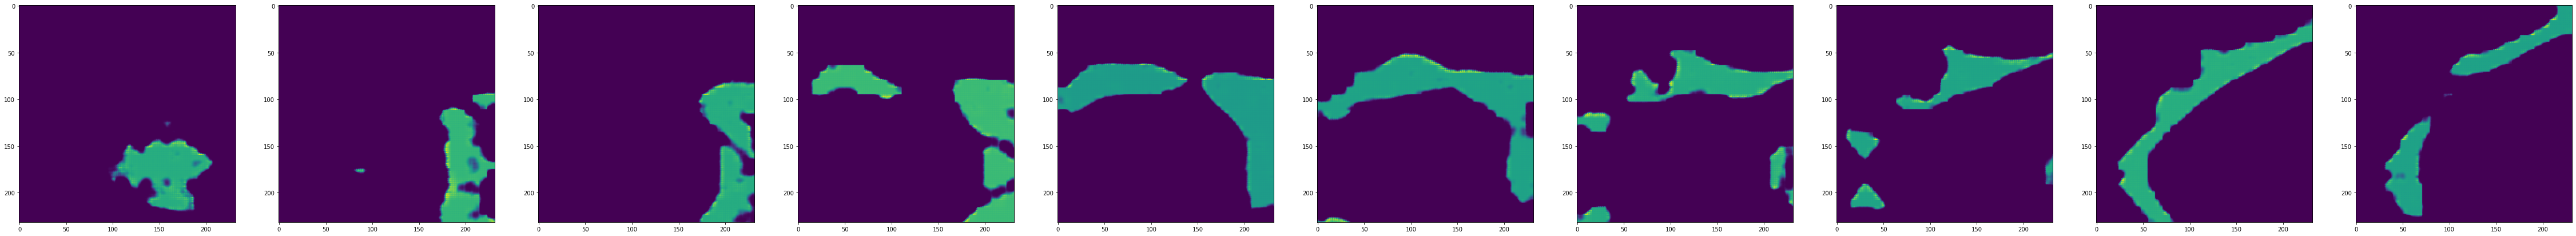

In [112]:
plot_data(irm)

In [113]:
data_decoded2 = vae.decoder.predict([[  -.327507,   .573899, -.502907, -.355825,  1.970033]]).reshape(image_size, image_size, image_size)

In [114]:
def plot_data(data):
  # generate figure
  fig = plt.figure()
  fig, (ax1, ax2 ,ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(nrows=1, ncols=10, figsize=(80, 50))
  fig, (ax11, ax22 ,ax33, ax44, ax55, ax66, ax77, ax88, ax99, ax110) = plt.subplots(nrows=1, ncols=10, figsize=(80, 50))

  ax1.imshow(data[:, 20, :])
  ax2.imshow(data[:, 40, :])
  ax3.imshow(data[:, 60, :])
  ax4.imshow(data[:, 80, :])
  ax5.imshow(data[:, 100, :])
  ax6.imshow(data[:, 110, :])
  ax7.imshow(data[:, 120, :])
  ax8.imshow(data[:, 140, :])
  ax9.imshow(data[:, 160, :])
  ax10.imshow(data[:, 180, :])

  ax11.imshow(data_decoded2[:, 20, :])
  ax22.imshow(data_decoded2[:, 40, :])
  ax33.imshow(data_decoded2[:, 60, :])
  ax44.imshow(data_decoded2[:, 80, :])
  ax55.imshow(data_decoded2[:, 100, :])
  ax66.imshow(data_decoded2[:, 110, :])
  ax77.imshow(data_decoded2[:, 120, :])
  ax88.imshow(data_decoded2[:, 140, :])
  ax99.imshow(data_decoded2[:, 160, :])
  ax110.imshow(data_decoded2[:, 180, :])
  plt.show


<Figure size 432x288 with 0 Axes>

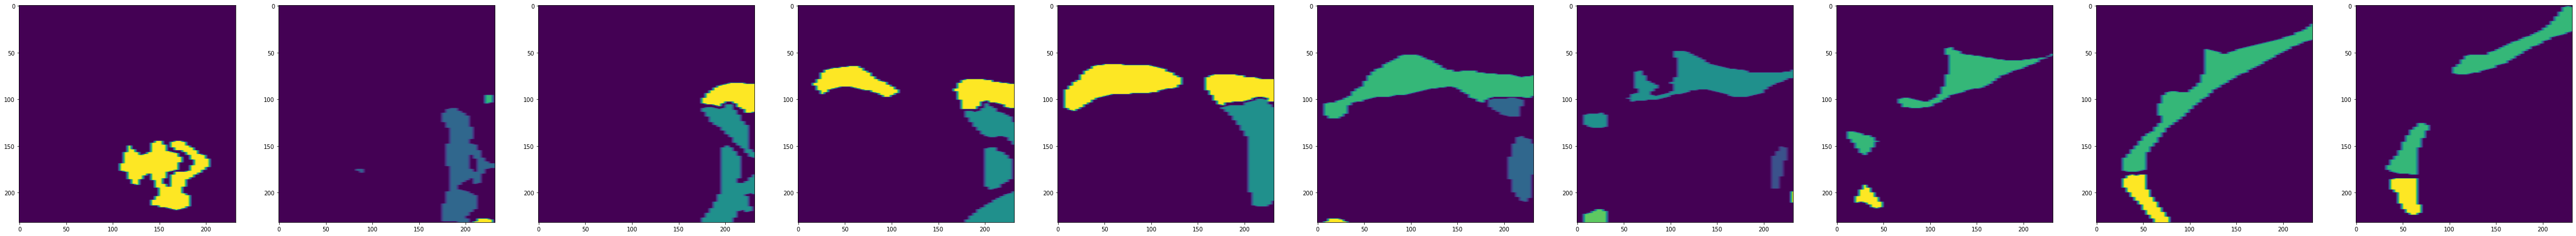

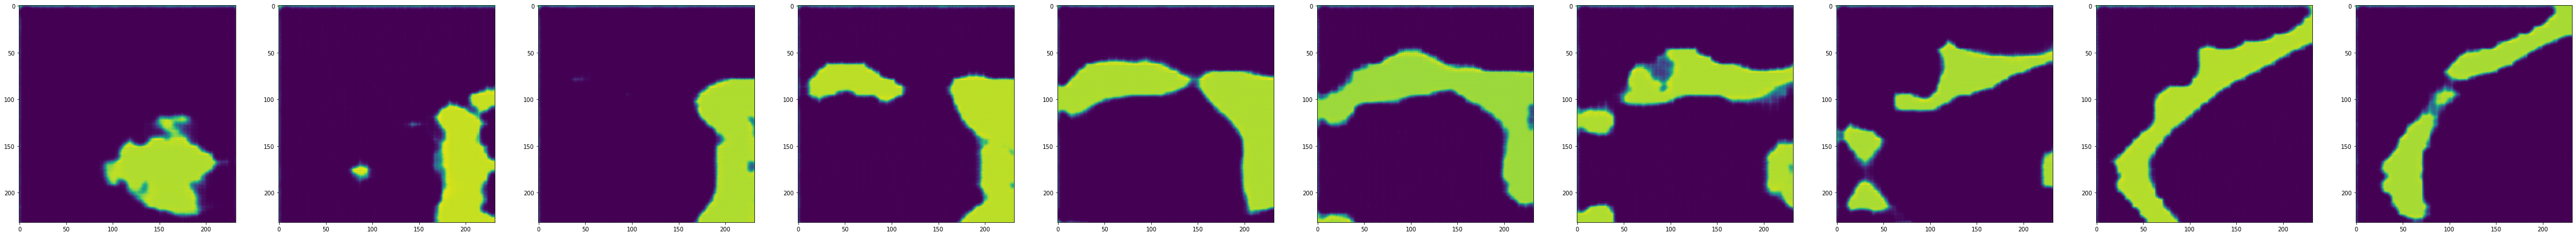

In [115]:
plot_data(irm)

## Evaluation du modèle


La partie encodeur du VAE produit une distribution postérieure approximative $q(z|x)$  et est paramétrée sur un réseau neuronal par des poids collectivement appelés $\phi$. Par conséquent, nous écrivons plus correctement l'encodeur comme $q_{\phi}(z|x)$. 
De même, la partie décodeur du VAE produit une distribution de vraisemblance $p(x|z)$, et est paramétrée sur un réseau neuronal par des poids collectivement désignés par $\theta$ et nous désignons plus correctement la partie décodeur du VAE par $p_{\theta}(x|z)$. La sortie de l'encodeur est constituée des paramètres de la distribution latente, qui est échantillonnée pour produire l'entrée du décodeur.

La divergence de KL entre les distributions postérieures approximative et réelle est donnée par 

$$ D_{KL}(q_{\phi}(z|x_i)\|p_{\theta}(z|x_i)) = - \int q_{\phi}(z|x_i)  \log  \left( \frac{p_{\theta}(z|x_i)}{q_{\phi}(z|x_i)} \right)dz \geq 0 $$

La fonction de coût qu'on veut minimizer est :
$$D_{KL}(q_{\phi}(z|x_i)\|p(z)) +  \mathbb{E}_{\sim q_{\phi}(z|x_i)}  \left[ \log   p_{\theta}(x_i|z) \right]$$




![picture](https://drive.google.com/uc?export=view&id=1yF7ymc6oMg7rf-vtalVy19KHx4S8_QEX)
